<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 6 - Modelo LSTM - Multivariado - Unistep</h3>
    <h3>Ejercicio 1_Asincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelo LSTM**  

Las LSTM son un tipo especial de redes recurrentes. La característica principal de las redes recurrentes es que la información puede persistir introduciendo bucles en el diagrama de la red, por lo que, básicamente, pueden «recordar» estados previos y utilizar esta información para decidir cuál será el siguiente.  
Esta característica las hace muy adecuadas para manejar series cronológicas. Mientras las redes recurrentes estándar pueden modelar dependencias a corto plazo (es decir, relaciones cercanas en la serie cronológica), las LSTM pueden aprender dependencias largas, por lo que se podría decir que tienen una «memoria» a más largo plazo.  

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

**Objetivo del Ejercicio**: Tomando como referencia los datos del Instituto Planck para Biogeoquímica que contiene el registro histórico de diferentes variables climáticas, queremos **elaborar modelos predictivos Multivariados y Unistep basados en Redes LSTM** para predecir la temperatura.  

Variables del dataset:  

*p (mbar):* presión del aire en milibars  
*T (degC):* temperatura del aire en °C  
*Tpot (K):* temperatura potencial  
*Tdew (degC):* temperatura de punto de rocío (a la cual el vapor de agua se condensa)  
*rh (%):* humedad relativa  
*VPmax (mbar):* presión de vapor de agua de saturación  
*VPact (mbar):* presión de vapor de agua real  
*VPdef (mbar):* déficit de presión de vapor de agua  
*sh (g/kg):* humedad específica  
*H2OC (mmol/mol):* nivel de concentración del vapor de agua  
*rho (g/m**3):* densidad del aire  
*wv (m/s):* velocidad del viento  
*max. wv (m/s):* velocidad del viento máxima  
*wd (deg):* dirección del viento  
*SWDR (W/m²):* Environmental variables-global radiation  

La variable a predecir: que es simplemente la variable que queremos pronosticar y que será la salida de cada uno de los modelos LSTM. En este caso esta variable a predecir es la temperatura (columna T (degC) de nuestro dataset).

## **Tareas a realizar:**  

Comentario: se inicia ya con el dataset limpio y preprocesado *temp_preprocesado*

1- Ejecutar de manera integral el script presentado, haciendo foco en la separación de los datos y en la adaptabilidad de los mismos como input del modelo LSTM.

2- Que diferencia principal (estructural) se encuentra a la hora de utilizar muchas variables para predecir una serie de tiempo.

3- En la sección  "Entrenamiento del modelo", que conclusiones se observan en la gráfica? Que parámetros consideraría modificar para realizar un fine tuning del modelo?. Proponga sugerencias.

**Montaje de Drive personal para acceder a archivos/ datasets**

Carga de Librerías

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from sklearn.metrics import mean_squared_error
import math
from statistics import mean
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

Carga de datos

In [ ]:
url='https://raw.githubusercontent.com/braiandrago/AST/main/temp_preprocesado.csv'
df_preprocesado = pd.read_csv(url, index_col=0)
print(df_preprocesado.shape)
df_preprocesado.head()

(9173, 21)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-01 00:10:00,984.99,15.21,289.61,15.19,99.9,17.31,17.29,0.02,10.99,17.56,...,1.02,1.32,208.1,0.0,0.0,0.0,0.0,0.0,27.10,450.3
2023-07-01 00:20:00,985.00,15.03,289.43,15.03,100.0,17.11,17.11,0.00,10.88,17.37,...,0.47,1.11,219.9,0.0,0.0,0.0,0.0,0.0,27.05,451.0
2023-07-01 00:30:00,984.98,14.86,289.26,14.64,98.6,16.92,16.69,0.24,10.61,16.94,...,1.06,1.77,226.7,0.0,0.0,0.0,0.0,0.0,26.97,439.4
2023-07-01 00:40:00,984.91,14.91,289.32,14.47,97.2,16.98,16.50,0.48,10.49,16.76,...,1.29,1.89,242.1,0.0,0.0,0.0,0.0,0.0,26.87,438.2
2023-07-01 00:50:00,984.92,14.77,289.17,14.46,98.0,16.83,16.49,0.34,10.48,16.74,...,1.45,2.06,238.6,0.0,0.0,0.0,0.0,0.0,26.73,440.0


En la carga del dataset ya asignamos a la primer columna como index (deja de ser considerada como variable el tiempo para las predicciones). Pero la eliminamos para alivianar la parte gráfica

In [ ]:
df_preprocesado = df_preprocesado.reset_index()
df_preprocesado = df_preprocesado.drop(columns=['datetime'])
df_preprocesado

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,984.99,15.21,289.61,15.19,99.90,17.31,17.29,0.02,10.99,17.56,...,1.02,1.32,208.10,0.0,0.0,0.00,0.00,0.00,27.10,450.3
1,985.00,15.03,289.43,15.03,100.00,17.11,17.11,0.00,10.88,17.37,...,0.47,1.11,219.90,0.0,0.0,0.00,0.00,0.00,27.05,451.0
2,984.98,14.86,289.26,14.64,98.60,16.92,16.69,0.24,10.61,16.94,...,1.06,1.77,226.70,0.0,0.0,0.00,0.00,0.00,26.97,439.4
3,984.91,14.91,289.32,14.47,97.20,16.98,16.50,0.48,10.49,16.76,...,1.29,1.89,242.10,0.0,0.0,0.00,0.00,0.00,26.87,438.2
4,984.92,14.77,289.17,14.46,98.00,16.83,16.49,0.34,10.48,16.74,...,1.45,2.06,238.60,0.0,0.0,0.00,0.00,0.00,26.73,440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,995.30,22.06,295.61,14.99,64.21,26.58,17.07,9.51,10.73,17.15,...,1.39,2.56,18.84,0.0,0.0,258.86,519.03,586.25,38.16,409.5
9169,995.29,21.88,295.43,14.92,64.65,26.29,17.00,9.29,10.69,17.08,...,1.83,3.15,33.91,0.0,0.0,212.36,425.47,494.95,38.08,409.9
9170,995.35,21.78,295.32,15.17,66.10,26.13,17.27,8.86,10.86,17.35,...,1.76,2.43,33.65,0.0,0.0,203.64,407.30,431.60,37.92,409.4
9171,995.43,21.83,295.37,15.36,66.68,26.21,17.48,8.73,10.99,17.56,...,1.27,2.88,34.50,0.0,0.0,287.23,560.17,679.49,37.68,409.0


comentario 1- Analizar si conveniente realizar ingeniería de variables y llevarlo adelante para alimentar el modelo.

**Feature Engineering**

Procesamos y modificamos algunas variables para generar nuevas características que alimenten el modelo. En este caso generamos las componentes de velocidad del viento.

In [ ]:
# Feature engineering
w_dir = df_preprocesado['wd (deg)']*np.pi/180 #pase a radianes
Wx = df_preprocesado['wv (m/s)']*np.cos(w_dir) #calculo de componente en x
Wy = df_preprocesado['wv (m/s)']*np.sin(w_dir) #calculo de componentes en y

# Eliminar columnas irrelevantes
df_preprocesado.pop('wd (deg)')
df_preprocesado.pop('wv (m/s)')
df_preprocesado.pop('max. wv (m/s)') #pues resulta redundante, teniendo en cuenta que existe la covariable wv (m/s)

# E incluir las columnas de interés
df_preprocesado['Wx'] = Wx
df_preprocesado['Wy'] = Wy
df_preprocesado

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm),Wx,Wy
0,984.99,15.21,289.61,15.19,99.90,17.31,17.29,0.02,10.99,17.56,1182.04,0.0,0.0,0.00,0.00,0.00,27.10,450.3,-0.899769,-0.480432
1,985.00,15.03,289.43,15.03,100.00,17.11,17.11,0.00,10.88,17.37,1182.88,0.0,0.0,0.00,0.00,0.00,27.05,451.0,-0.360568,-0.301481
2,984.98,14.86,289.26,14.64,98.60,16.92,16.69,0.24,10.61,16.94,1183.74,0.0,0.0,0.00,0.00,0.00,26.97,439.4,-0.726967,-0.771439
3,984.91,14.91,289.32,14.47,97.20,16.98,16.50,0.48,10.49,16.76,1183.54,0.0,0.0,0.00,0.00,0.00,26.87,438.2,-0.603629,-1.140058
4,984.92,14.77,289.17,14.46,98.00,16.83,16.49,0.34,10.48,16.74,1184.13,0.0,0.0,0.00,0.00,0.00,26.73,440.0,-0.755464,-1.237649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9168,995.30,22.06,295.61,14.99,64.21,26.58,17.07,9.51,10.73,17.15,1166.88,0.0,0.0,258.86,519.03,586.25,38.16,409.5,1.315529,0.448868
9169,995.29,21.88,295.43,14.92,64.65,26.29,17.00,9.29,10.69,17.08,1167.62,0.0,0.0,212.36,425.47,494.95,38.08,409.9,1.518744,1.020939
9170,995.35,21.78,295.32,15.17,66.10,26.13,17.27,8.86,10.86,17.35,1167.95,0.0,0.0,203.64,407.30,431.60,37.92,409.4,1.465091,0.975248
9171,995.43,21.83,295.37,15.36,66.68,26.21,17.48,8.73,10.99,17.56,1167.76,0.0,0.0,287.23,560.17,679.49,37.68,409.0,1.046640,0.719336


# Procesamiento del dataset

comentario 2- Decidir que divisiones realizar en el dataset y completar en la función "train_val_test_split() según el criterio adoptado"

En lugar de introducir una serie de Pandas, introduciremos el DataFrame completo.

In [ ]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

In [ ]:
# Prueba de la función
tr, vl, ts = train_val_test_split(df_preprocesado)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (7338, 20)
Tamaño set de validación: (917, 20)
Tamaño set de prueba: (918, 20)


**Gráfica representativa del split para una feature**

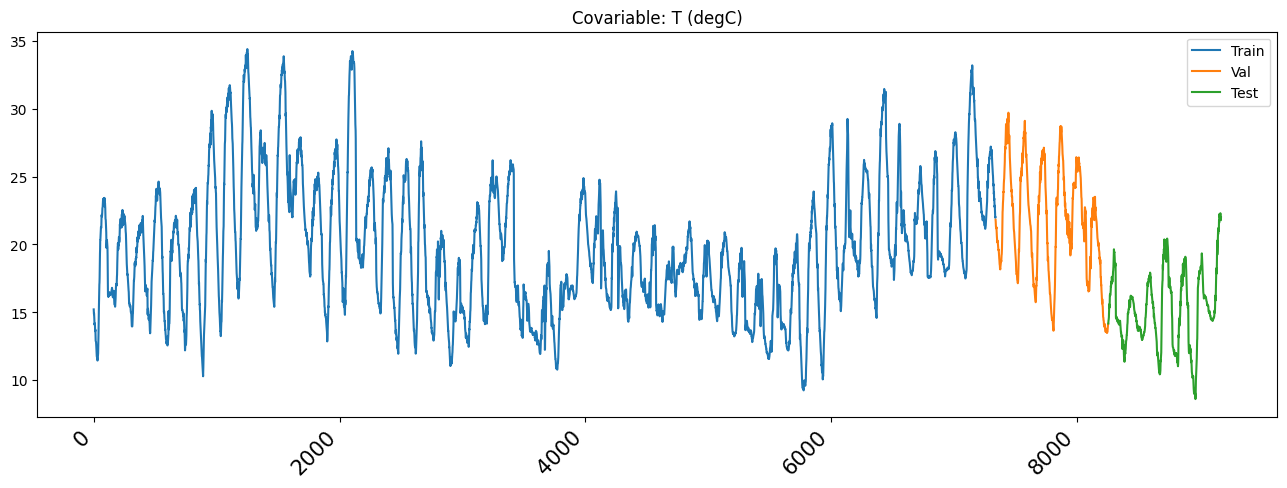

In [ ]:
covar = 1 # Índice de la covariable (columna del dataset) a graficar
col = df_preprocesado.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize = 15)
plt.legend();

**Dataset supervisado**

Ajustaremos nuestros sets de entrenamiento, validación y prueba al formato requerido por la Red LSTM para realizar el entrenamiento y posteriormente las predicciones.  
Para este modelo, puntualmente ingresaremos al mismo registros continuos de 240 minutos x 20 features(4 horas = 14400 segundos) es decir, para las variables del dataset y el modelo deberá aprender a predecir 10 min a futuro (600seg)  

Es decir, tomaremos bloques consecutivos de las 20 variables de 4 horas (24 registros) cada uno para introducirlos al modelo.

Debemos estructurar nuestros sets de la siguiente manera:  

*Entrada (X):* arreglo de tamaño batches x input_length x features  
*Salida (Y):* arreglo de tamaño batches x output_length x features

- Un arreglo de 240 (minutos) x 20 (features) correspondiente a la entrada
- Un arreglo de 40 (minutos) x 1 (feature)

In [ ]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        #Salida (el índice 1 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,1].reshape(output_length,1)) #<--Importante!

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [ ]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (7313, 24, 20), y_tr: (7313, 1, 1)
Set de validación - x_vl: (892, 24, 20), y_vl: (892, 1, 1)
Set de prueba - x_ts: (893, 24, 20), y_ts: (893, 1, 1)


**Escalamiento de los datos**

Es recomendable, al utilizar modelos de deep learning, asegurar que las variables que alimentan el modelo se encuentran en el mismo rango de valores. (Mejora el algoritmo de predicción y por lo tanto las predicciones)

Lo anterior implica que la Red LSTM será entrenada con valores escalados y que, por tanto, generará predicciones dentro de esta escala (-1 a 1). Por esta razón, una vez entrenado el modelo y al momento de generar las predicciones tendremos que realizar un escalamiento inverso, llevando las predicciones del rango de -1 a 1 al rango normal de temperaturas.

En comparación con entradas univariadas, en este caso por tener múltiples variables de entrada se requiere escalar cada una de ellas a la entrada del modelo

In [ ]:
def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df_preprocesado.columns.get_loc(col_ref) #nuestra columna de referencia, para el escalamiento inverso que se hace después

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2] #20

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)] #20 escaladores

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind"), solo el de la variable temperatura
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [ ]:
# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'T (degC)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

Comprobamos los rangos gráficamente

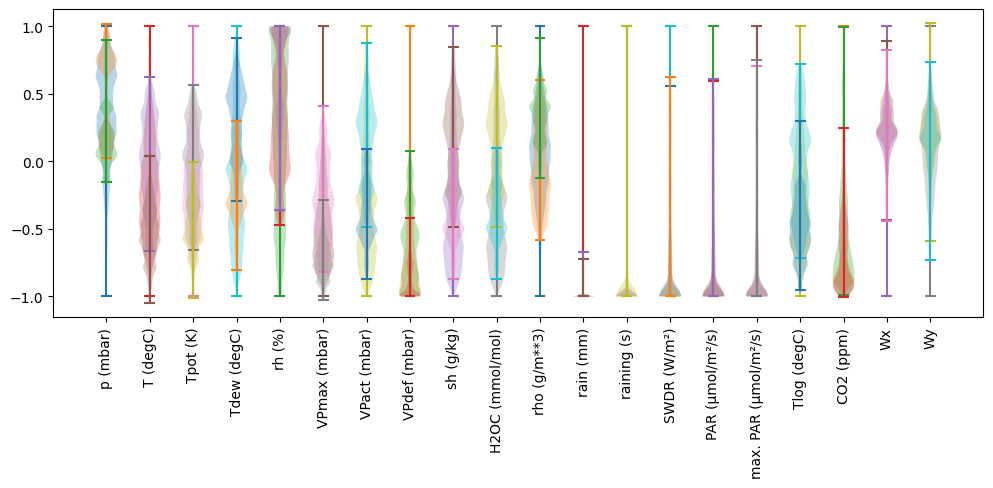

In [ ]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(20):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(20)))
ax.set_xticklabels(df_preprocesado.keys(), rotation=90)
ax.autoscale();

# Creación y entrenamiento de la Red LSTM

**Creación de la Red LSTM**

In [ ]:
# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

In [ ]:
# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 240 (minutos) x 20 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE,return_sequences=True))
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + uni-step es
# el tamaño del dato de salida (1 hora)
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))

**Compilación del modelo**

In [ ]:
# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

**Entrenamiento del modelo**

In [ ]:
# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
29/29 - 13s - loss: 0.2396 - val_loss: 0.1132 - 13s/epoch - 440ms/step
Epoch 2/80
29/29 - 8s - loss: 0.1170 - val_loss: 0.0898 - 8s/epoch - 271ms/step
Epoch 3/80
29/29 - 7s - loss: 0.0926 - val_loss: 0.0766 - 7s/epoch - 228ms/step
Epoch 4/80
29/29 - 8s - loss: 0.0786 - val_loss: 0.0631 - 8s/epoch - 270ms/step
Epoch 5/80
29/29 - 7s - loss: 0.0709 - val_loss: 0.0617 - 7s/epoch - 228ms/step
Epoch 6/80
29/29 - 9s - loss: 0.0663 - val_loss: 0.0606 - 9s/epoch - 302ms/step
Epoch 7/80
29/29 - 8s - loss: 0.0626 - val_loss: 0.0647 - 8s/epoch - 271ms/step
Epoch 8/80
29/29 - 7s - loss: 0.0607 - val_loss: 0.0549 - 7s/epoch - 228ms/step
Epoch 9/80
29/29 - 8s - loss: 0.0582 - val_loss: 0.0579 - 8s/epoch - 270ms/step
Epoch 10/80
29/29 - 7s - loss: 0.0564 - val_loss: 0.0543 - 7s/epoch - 227ms/step
Epoch 11/80
29/29 - 8s - loss: 0.0550 - val_loss: 0.0516 - 8s/epoch - 282ms/step
Epoch 12/80
29/29 - 9s - loss: 0.0536 - val_loss: 0.0517 - 9s/epoch - 327ms/step
Epoch 13/80
29/29 - 7s - loss: 0.05

Al completar las 80 iteraciones de entrenamiento podremos generar una gráfica de la variable historia para obtener las curvas del comportamiento de la pérdida con los sets de entrenamiento y validación.

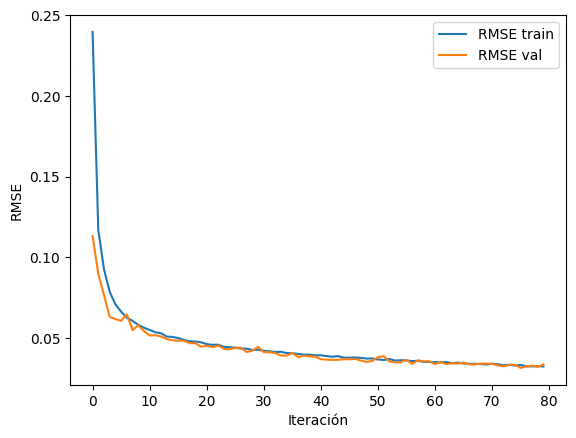

In [ ]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

COMPLETAR CON CONCLUSIONES DE LA GRAFICA.  
Que se observa en la misma?  
Cómo haría fine tuning al modelo? Pruebe y reproduzca el cálculo con las modificaciones consideradas (ajuste en cuando a parámetros de la red).


**Desempeño del Modelo**

Ahora, verificaremos el desempeño del modelo usando el set de datos que hasta el momento no hemos presentado a la Red: el set de prueba.

In [ ]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

In [ ]:
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.031
  RMSE val:	 0.032
  RMSE test:	 0.030


In [ ]:
# 1. Generar las predicciones sobre el set de prueba
#y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Realizar la transformación inversa de las predicciones para llevar sus
# valores a la escala original
#y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 3. Calcular RMSE para cada instante de tiempo predicho
#diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # BATCHESx4
#proms = np.mean(diff_cuad, axis=0) # 1x4
#rmse = np.sqrt(proms) # 1x4

# Graficar rmse para cada timestep
#t = np.linspace(1,4,4)

#fig, ax = plt.subplots()
#ax.scatter(t,rmse)
#ax.set_xlabel('Intevalo de 10min predicho')
#ax.set_ylabel('Error RMSE (°C)')
#plt.xticks(ticks=t, labels=t)
#plt.grid();

**Predicciones (forecasting) con el modelo entrenado**

In [ ]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [ ]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)

Analicemos este desempeño gráficamente mostrando las temperaturas originales y las predichas por el modelo para cada uno de los datos en el set de prueba:

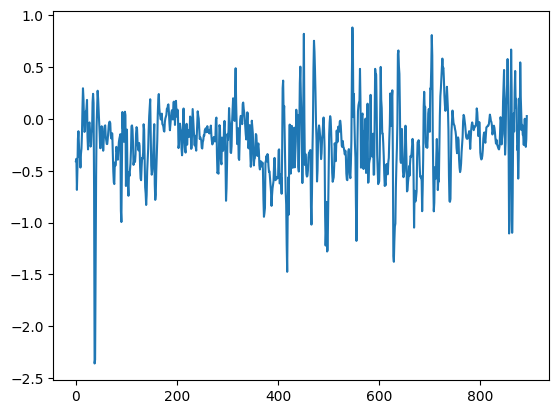

In [ ]:
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

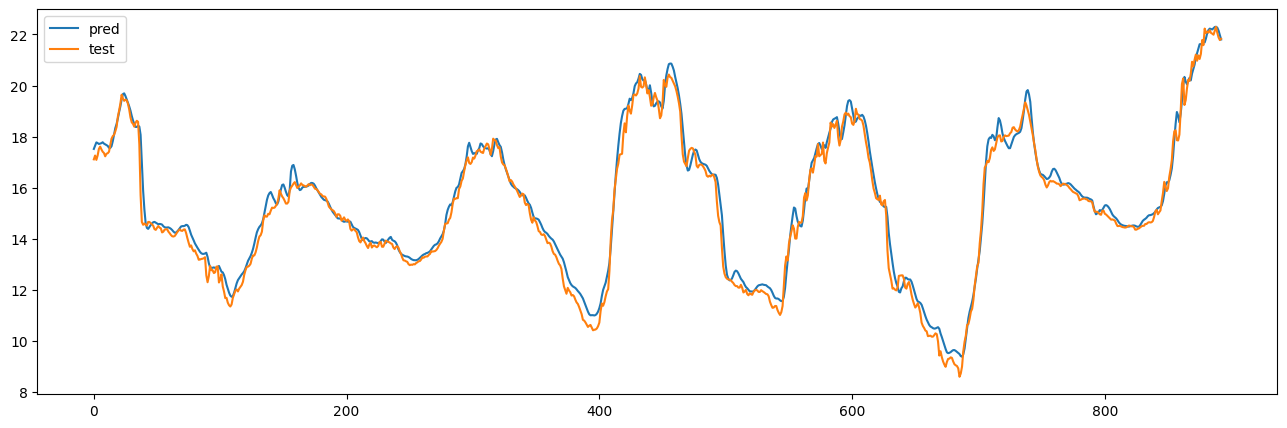

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(y_ts_pred,label="pred")
ax.plot(y_ts.flatten(),label="test")
plt.legend();